In [4]:
import numpy as np
import os
from utils.utilities import *
from sklearn.model_selection import train_test_split
#import matplotlib.pyplot as plt
import pandas as pd
#import seaborn as sns
#%matplotlib inline

In [5]:
X_train, labels_train, list_ch_train = read_data(data_path="../data/HAR_Dataset", split="train") # train
X_test, labels_test, list_ch_test = read_data(data_path="../data/HAR_Dataset", split="test") # test

assert list_ch_train == list_ch_test, "Mistmatch in channels!"

In [8]:
set(labels_train)

{1, 2, 3, 4, 5, 6}

In [4]:
list_ch_train

['body_acc_x',
 'body_acc_y',
 'body_acc_z',
 'body_gyro_x',
 'body_gyro_y',
 'body_gyro_z',
 'total_acc_x',
 'total_acc_y',
 'total_acc_z']

In [3]:
print ("Training data shape: N = {:d}, steps = {:d}, channels = {:d}".format(X_train.shape[0],
                                                                             X_train.shape[1],
                                                                             X_train.shape[2]))
print ("Test data shape: N = {:d}, steps = {:d}, channels = {:d}".format(X_test.shape[0],
                                                                         X_test.shape[1],
                                                                         X_test.shape[2]))

Training data shape: N = 7352, steps = 128, channels = 9
Test data shape: N = 2947, steps = 128, channels = 9


In [6]:
# Mean value for each channel at each step
all_data = np.concatenate((X_train,X_test), axis = 0)
means_ = np.zeros((all_data.shape[1],all_data.shape[2]))
stds_ = np.zeros((all_data.shape[1],all_data.shape[2]))

for ch in range(X_train.shape[2]):
    means_[:,ch] = np.mean(all_data[:,:,ch], axis=0)
    stds_[:,ch] = np.std(all_data[:,:,ch], axis=0)
    
df_mean = pd.DataFrame(data = means_)
df_std = pd.DataFrame(data = stds_)

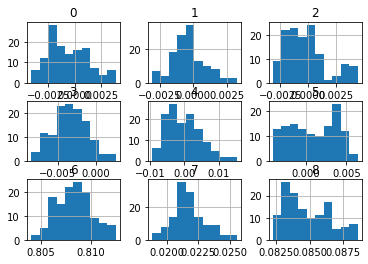

In [7]:
df_mean.hist()
plt.show()

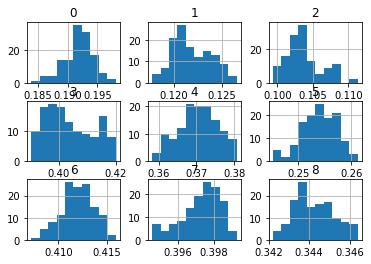

In [8]:
df_std.hist()
plt.show()

In [9]:
X_train, X_test = standardize(X_train, X_test)

In [10]:
# Check Mean value for each channel at each step
all_data = np.concatenate((X_train,X_test), axis = 0)
means_ = np.zeros((all_data.shape[1],all_data.shape[2]))
stds_ = np.zeros((all_data.shape[1],all_data.shape[2]))

for ch in range(X_train.shape[2]):
    means_[:,ch] = np.mean(all_data[:,:,ch], axis=0)
    stds_[:,ch] = np.std(all_data[:,:,ch], axis=0)
    
df_mean = pd.DataFrame(data = means_)
df_std = pd.DataFrame(data = stds_)

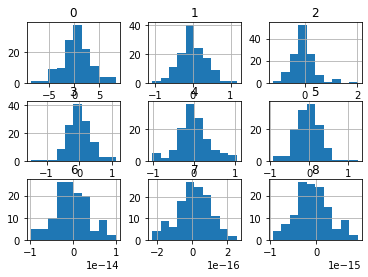

In [11]:

df_mean.hist()
plt.show()

In [12]:

# Imports
import numpy as np
import os
from utils.utilities import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
X_train, labels_train, list_ch_train = read_data(data_path="../data/HAR_Dataset", split="train") # train
X_test, labels_test, list_ch_test = read_data(data_path="../data/HAR_Dataset", split="test") # test

assert list_ch_train == list_ch_test, "Mistmatch in channels!"

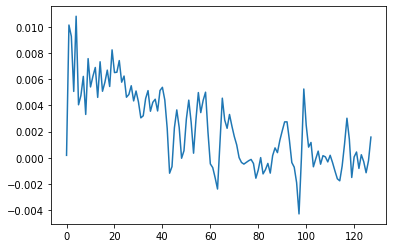

In [15]:
plt.plot(X_train[0,:,0])

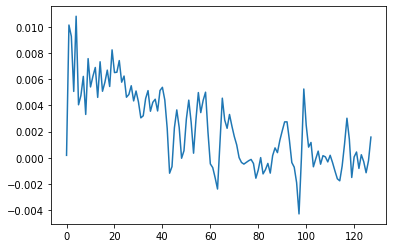

In [17]:
plt.plot(X_train[:,:,np.newaxis,:][0,:,0,0])

In [21]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import csv
import tempfile
import zipfile
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, Activation,Reshape
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import layers
#from tensorflow.keras.backend.tensorflow_backend import set_session
from tensorflow.keras import backend as K
from utils.utilities import *
import matplotlib.pyplot as plt


np.random.seed(813306)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 忽略 Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2
#tf.logging.set_verbosity(tf.logging.ERROR)
#config = tf.ConfigProto()
#config.gpu_options.allocator_type = 'BFC'  # A "Best-fit with coalescing" algorithm, simplified from a version of dlmalloc.
#config.gpu_options.per_process_gpu_memory_fraction = 1
#config.gpu_options.allow_growth = True
#set_session(tf.Session(config=config))


#数据预处理
tf.keras.backend.set_image_data_format('channels_last')
#构建数据集 channel_last
#构建数据集 channel_last
def load_data():    
    X_train, labels_train, list_ch_train = read_data(data_path="../data/HAR_Dataset", split="train") # train
    X_test, labels_test, list_ch_test = read_data(data_path="../data/HAR_Dataset", split="test") # test
    assert list_ch_train == list_ch_test, "Mistmatch in channels!"
    x_train = X_train[:,:,np.newaxis,:]
    x_val = X_test[:,:,np.newaxis,:]
    y_train = to_categorical(labels_train)
    y_val = to_categorical(labels_test)
    return (x_train,y_train),(x_val,y_val)





def build_resnet(input_shape, n_feature_maps, nb_classes, dropout):
    print('build conv_x')
    x = Input(shape=(input_shape))

    x_total = keras.layers.Conv2D(10, (17, 1),strides = (1,1), padding='same')(x)
    conv_x = keras.layers.BatchNormalization()(x_total)  # 853

 
    conv_x = keras.layers.Conv2D(n_feature_maps, (17, 1), padding='same')(conv_x)  # input size == ouput size
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = Activation('relu')(conv_x)

    print('build conv_y')
    conv_y = keras.layers.Conv2D(n_feature_maps * 2, (17, 1), padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = Activation('relu')(conv_y)

    conv_y = Dropout(dropout)(conv_y)
    print('build conv_z')
    conv_z = keras.layers.Conv2D(n_feature_maps, (9, 1), padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    is_expand_channels = not (input_shape[-1] == n_feature_maps)  # 若当前输出和跨层连接的x，通道数不同，则采用1*1卷积使得通道数相同
    if is_expand_channels:
        shortcut_y = keras.layers.Conv2D(n_feature_maps, (1, 1), padding='same')(x_total)
        shortcut_y = keras.layers.BatchNormalization()(shortcut_y)
    else:
        shortcut_y = keras.layers.BatchNormalization()(x_total)

    print('Merging skip connection')
    # y = merge([shortcut_y, conv_z], mode='sum')
    y = keras.layers.Add()([shortcut_y, conv_z])
    y = Activation('relu')(y)


    full = keras.layers.GlobalAveragePooling2D()(y)
    out = Dense(nb_classes, activation='softmax')(full)
    print('        -- model was built.')
    return x, out


if __name__ == '__main__':
    num = 6
    channels = 3
    dropout = 0.2
    nb_epochs = 700
    batch_size = 50
    data_row = 128
    data_column = 1
    trainpath = r'./data'

    (x_train,y_train),(x_val,y_val) = load_data()


    tf.keras.backend.set_image_data_format('channels_last')


    input_shape = (data_row, data_column,channels)

    print('train dataset size:',x_train.shape[0])
    print('validation dataset size:',x_val.shape[0])
    num_classes = y_train.shape[1]
    
    x, y = build_resnet(input_shape, 64, num, dropout)  # 建立resnet只考虑了单个example
    model = Model(inputs=x, outputs=y)
    model.summary()
    optimizer = keras.optimizers.Adam()
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.9,
                                  patience=20, min_lr=0.00005)
    hist = model.fit(x_train, y_train, batch_size=batch_size, epochs=nb_epochs,
                     verbose=1, validation_data=(x_val, y_val), callbacks=[reduce_lr])  # 回调函数会在训练的时候适当被调用


    # 测试
    print("------------------------ 测试中---------------------------")
    #evaluation of the model
    scores = model.evaluate(x_val,y_val)
    print('Baseline Error: %.2f%%'%(100 * (1 - scores[1])))
    keras.models.save_model(model, '../model/HAR.h5')
    keras_file = '../model/HAR.h5'
    _, zip1 = tempfile.mkstemp('.zip') 
    with zipfile.ZipFile(zip1, 'w', compression=zipfile.ZIP_DEFLATED) as f:
        f.write(keras_file)
    print("Size of the unpruned model before compression: %.2f Mb" % 
          (os.path.getsize(keras_file) / float(2**20)))
    print("Size of the unpruned model after compression: %.2f Mb" % 
          (os.path.getsize(zip1) / float(2**20)))


train dataset size: 7352
validation dataset size: 2947
build conv_x
build conv_y
build conv_z
Merging skip connection
        -- model was built.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 1, 9)]  0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 128, 1, 10)   1540        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 128, 1, 10)   40          conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 128, 1

7352/7352 [==============================] - 8s 1ms/sample - loss: 0.2397 - accuracy: 0.9240 - val_loss: 0.6816 - val_accuracy: 0.7282
Epoch 2/700
7352/7352 [==============================] - 2s 334us/sample - loss: 0.1389 - accuracy: 0.9470 - val_loss: 0.5084 - val_accuracy: 0.8521
Epoch 3/700
7352/7352 [==============================] - 2s 332us/sample - loss: 0.1396 - accuracy: 0.9440 - val_loss: 0.2499 - val_accuracy: 0.9125
Epoch 4/700
7352/7352 [==============================] - 2s 334us/sample - loss: 0.1203 - accuracy: 0.9506 - val_loss: 0.2616 - val_accuracy: 0.9199
Epoch 5/700
7352/7352 [==============================] - 2s 330us/sample - loss: 0.1397 - accuracy: 0.9436 - val_loss: 0.2397 - val_accuracy: 0.9247
Epoch 6/700
7352/7352 [==============================] - 2s 332us/sample - loss: 0.1169 - accuracy: 0.9499 - val_loss: 0.2021 - val_accuracy: 0.9264
Epoch 7/700
7352/7352 [==============================] - 2s 329us/sample - loss: 0.1274 - accuracy: 0.9478 - val_loss: 0

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import csv
import tempfile
import zipfile
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, Activation,Reshape
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import layers
#from tensorflow.keras.backend.tensorflow_backend import set_session
from tensorflow.keras import backend as K
from utils.utilities import *
import matplotlib.pyplot as plt


np.random.seed(813306)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 忽略 Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2
#tf.logging.set_verbosity(tf.logging.ERROR)
#config = tf.ConfigProto()
#config.gpu_options.allocator_type = 'BFC'  # A "Best-fit with coalescing" algorithm, simplified from a version of dlmalloc.
#config.gpu_options.per_process_gpu_memory_fraction = 1
#config.gpu_options.allow_growth = True
#set_session(tf.Session(config=config))


#数据预处理
tf.keras.backend.set_image_data_format('channels_last')
#构建数据集 channel_last
#构建数据集 channel_last
def load_data():    
    X_train, labels_train, list_ch_train = read_data(data_path="../data/HAR_Dataset", split="train") # train
    X_test, labels_test, list_ch_test = read_data(data_path="../data/HAR_Dataset", split="test") # test
    assert list_ch_train == list_ch_test, "Mistmatch in channels!"
    x_train = X_train[:,:,np.newaxis,:]
    x_val = X_test[:,:,np.newaxis,:]
    y_train = to_categorical(labels_train)
    y_val = to_categorical(labels_test)
    return (x_train,y_train),(x_val,y_val)





def build_resnet(input_shape, n_feature_maps, nb_classes, dropout):
    print('build conv_x')
    x = Input(shape=(input_shape))
    x_total = []
    for i in range(input_shape[-1]):
        x_temp = Reshape((input_shape[0],1,1))(x[:,:,:,i])
        
        x_temp = keras.layers.Conv2D(16, (16, 1),strides = (1,1), padding='same')(x_temp)
        x_temp = keras.layers.AveragePooling2D(pool_size=(3, 1), strides=None, padding='same', data_format=None)(x_temp)
        x_temp = keras.layers.BatchNormalization()(x_temp)
        x_temp = Activation('relu')(x_temp)
        
        x_temp = keras.layers.Conv2D(32, (16, 1),strides = (1,1), padding='same')(x_temp)
        x_temp = keras.layers.AveragePooling2D(pool_size=(3, 1), strides=None, padding='same', data_format=None)(x_temp)
        x_temp = keras.layers.BatchNormalization()(x_temp)
        x_temp = Activation('relu')(x_temp)
        
#         x_temp = keras.layers.Conv2D(16, (16, 1),strides = (1,1), padding='same')(x_temp)
#         x_temp = keras.layers.AveragePooling2D(pool_size=(3, 1), strides=None, padding='same', data_format=None)(x_temp)
#         x_temp = keras.layers.BatchNormalization()(x_temp)
#         x_temp = Activation('relu')(x_temp)
        
#         x_temp = keras.layers.Conv2D(16, (16, 1),strides = (1,1), padding='same')(x_temp)
#         x_temp = keras.layers.AveragePooling2D(pool_size=(2, 1), strides=None, padding='same', data_format=None)(x_temp)
#         x_temp = keras.layers.BatchNormalization()(x_temp)
#         x_temp = Activation('relu')(x_temp)
        
        x_temp = keras.layers.Conv2D(16, (16, 1),strides = (1,1), padding='same')(x_temp)
        x_temp = keras.layers.AveragePooling2D(pool_size=(2, 1), strides=None, padding='same', data_format=None)(x_temp)
        x_temp = keras.layers.BatchNormalization()(x_temp)
        x_temp = Activation('relu')(x_temp)
        
        x_temp = keras.layers.Conv2D(16, (16, 1),strides = (1,1), padding='same')(x_temp)
        x_temp = keras.layers.AveragePooling2D(pool_size=(2, 1), strides=None, padding='same', data_format=None)(x_temp)
        x_temp = keras.layers.BatchNormalization()(x_temp)
        x_temp = Activation('relu')(x_temp)
        
        x_temp = keras.layers.Conv2D(1, (8, 1),strides = (1,1), padding='same')(x_temp)
        
        
        x_total.append(x_temp)

    
    x_total = K.concatenate(x_total , axis=-1)
    conv_x = keras.layers.BatchNormalization()(x_total)  # 853
    
    # channel attention here
    '''
    x = keras.layers.GlobalAveragePooling2D()(inputs)
    x = keras.layers.Dense(int(x.shape[-1]) // self.reduction, use_bias=False,activation=keras.activations.relu)(x)
    x = keras.layers.Dense(int(inputs.shape[-1]), use_bias=False,activation=keras.activations.hard_sigmoid)(x)
    x = keras.layers.Multiply()([inputs,x])
    '''
 
    conv_x = keras.layers.Conv2D(n_feature_maps, (16, 1), padding='same')(conv_x)  # input size == ouput size
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = Activation('relu')(conv_x)
    

    '''
    print('build conv_y')
    conv_y = keras.layers.Conv2D(n_feature_maps * 2, (16, 1), padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = Activation('relu')(conv_y)

    conv_y = Dropout(dropout)(conv_y)
    '''
    print('build conv_z')
    conv_z = keras.layers.Conv2D(n_feature_maps, (8, 1), padding='same')(conv_x)
    #conv_z = keras.layers.BatchNormalization()(conv_x)

    is_expand_channels = not (input_shape[-1] == n_feature_maps)  # 若当前输出和跨层连接的x，通道数不同，则采用1*1卷积使得通道数相同
    if is_expand_channels:
        shortcut_y = keras.layers.Conv2D(n_feature_maps, (1, 1), padding='same')(x_total)
        #shortcut_y = keras.layers.BatchNormalization()(shortcut_y)
    else:
        shortcut_y = x_total#keras.layers.BatchNormalization()(x_total)

    #print('Merging skip connection')
    # y = merge([shortcut_y, conv_z], mode='sum')
    y = keras.layers.Add()([shortcut_y, conv_z])
    y = keras.layers.BatchNormalization()(y)
    y = Activation('relu')(y)


    full = keras.layers.GlobalAveragePooling2D()(y)
    out = Dense(nb_classes, activation='softmax')(full)
    print('        -- model was built.')
    return x, out

if __name__ == '__main__':
    num = 6
    channels = 9
    dropout = 0.2
    nb_epochs = 700
    batch_size = 50
    data_row = 128
    data_column = 1
    trainpath = r'./data'

    (x_train,y_train),(x_val,y_val) = load_data()


    tf.keras.backend.set_image_data_format('channels_last')


    input_shape = (data_row, data_column,channels)

    print('train dataset size:',x_train.shape[0])
    print('validation dataset size:',x_val.shape[0])
    num_classes = y_train.shape[1]
    
    x, y = build_resnet(input_shape, 64, num, dropout)  # 建立resnet只考虑了单个example
    model = Model(inputs=x, outputs=y)
    model.summary()
    optimizer = keras.optimizers.Adam()
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.9,
                                  patience=20, min_lr=0.00005)
    hist = model.fit(x_train, y_train, batch_size=batch_size, epochs=nb_epochs,
                     verbose=1, validation_data=(x_val, y_val), callbacks=[reduce_lr])  # 回调函数会在训练的时候适当被调用


    # 测试
    print("------------------------ 测试中---------------------------")
    #evaluation of the model
    scores = model.evaluate(x_val,y_val)
    print('Baseline Error: %.2f%%'%(100 * (1 - scores[1])))
    keras.models.save_model(model, '../model/test_resnet_v4.h5')
    keras_file = '../model/test_resnet_v4.h5'
    _, zip1 = tempfile.mkstemp('.zip') 
    with zipfile.ZipFile(zip1, 'w', compression=zipfile.ZIP_DEFLATED) as f:
        f.write(keras_file)
    print("Size of the unpruned model before compression: %.2f Mb" % 
          (os.path.getsize(keras_file) / float(2**20)))
    print("Size of the unpruned model after compression: %.2f Mb" % 
          (os.path.getsize(zip1) / float(2**20)))


train dataset size: 7352
validation dataset size: 2947
build conv_x
build conv_z
        -- model was built.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 1, 9)]  0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice (Tens [(None, 128, 1)]     0           input_1[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_strided_slice_1 (Te [(None, 128, 1)]     0           input_1[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_strided_slice_2 (Te [(None, 128, 1)]     0           input_1[0][0]      

KeyboardInterrupt: 

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import csv
import tempfile
import zipfile
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, Activation,Reshape
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import layers
#from tensorflow.keras.backend.tensorflow_backend import set_session
from tensorflow.keras import backend as K
from utils.utilities import *
import matplotlib.pyplot as plt


np.random.seed(813306)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 忽略 Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2
#tf.logging.set_verbosity(tf.logging.ERROR)
#config = tf.ConfigProto()
#config.gpu_options.allocator_type = 'BFC'  # A "Best-fit with coalescing" algorithm, simplified from a version of dlmalloc.
#config.gpu_options.per_process_gpu_memory_fraction = 1
#config.gpu_options.allow_growth = True
#set_session(tf.Session(config=config))


#数据预处理
tf.keras.backend.set_image_data_format('channels_last')
#构建数据集 channel_last
#构建数据集 channel_last
def load_data():    
    X_train, labels_train, list_ch_train = read_data(data_path="../data/HAR_Dataset", split="train") # train
    X_test, labels_test, list_ch_test = read_data(data_path="../data/HAR_Dataset", split="test") # test
    assert list_ch_train == list_ch_test, "Mistmatch in channels!"
    x_train = X_train[:,:,np.newaxis,:]
    x_val = X_test[:,:,np.newaxis,:]
    x_train = x_train[:,:,:,3:6]
    x_val = x_val[:,:,:,3:6]
    y_train = to_categorical(labels_train)
    y_val = to_categorical(labels_test)
    return (x_train,y_train),(x_val,y_val)





def build_resnet(input_shape, n_feature_maps, nb_classes, dropout):
    print('build conv_x')
    x = Input(shape=(input_shape))

    x_total = keras.layers.Conv2D(10, (17, 1),strides = (1,1), padding='same')(x)
    conv_x = keras.layers.BatchNormalization()(x_total)  # 853

 
    conv_x = keras.layers.Conv2D(n_feature_maps, (17, 1), padding='same')(conv_x)  # input size == ouput size
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = Activation('relu')(conv_x)

    print('build conv_y')
    conv_y = keras.layers.Conv2D(n_feature_maps * 2, (17, 1), padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = Activation('relu')(conv_y)

    conv_y = Dropout(dropout)(conv_y)
    print('build conv_z')
    conv_z = keras.layers.Conv2D(n_feature_maps, (9, 1), padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    is_expand_channels = not (input_shape[-1] == n_feature_maps)  # 若当前输出和跨层连接的x，通道数不同，则采用1*1卷积使得通道数相同
    if is_expand_channels:
        shortcut_y = keras.layers.Conv2D(n_feature_maps, (1, 1), padding='same')(x_total)
        shortcut_y = keras.layers.BatchNormalization()(shortcut_y)
    else:
        shortcut_y = keras.layers.BatchNormalization()(x_total)

    print('Merging skip connection')
    # y = merge([shortcut_y, conv_z], mode='sum')
    y = keras.layers.Add()([shortcut_y, conv_z])
    y = Activation('relu')(y)


    full = keras.layers.GlobalAveragePooling2D()(y)
    out = Dense(nb_classes, activation='softmax')(full)
    print('        -- model was built.')
    return x, out


if __name__ == '__main__':
    num = 7
    channels = 3
    dropout = 0.2
    nb_epochs = 700
    batch_size = 50
    data_row = 128
    data_column = 1
    trainpath = r'./data'

    (x_train,y_train),(x_val,y_val) = load_data()


    tf.keras.backend.set_image_data_format('channels_last')


    input_shape = (data_row, data_column,channels)

    print('train dataset size:',x_train.shape[0])
    print('validation dataset size:',x_val.shape[0])
    num_classes = y_train.shape[1]
    
    x, y = build_resnet(input_shape, 64, num, dropout)  # 建立resnet只考虑了单个example
    model = Model(inputs=x, outputs=y)
    model.summary()
    optimizer = keras.optimizers.Adam()
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.9,
                                  patience=20, min_lr=0.00005)
    hist = model.fit(x_train, y_train, batch_size=batch_size, epochs=nb_epochs,
                     verbose=1, validation_data=(x_val, y_val), callbacks=[reduce_lr])  # 回调函数会在训练的时候适当被调用


    # 测试
    print("------------------------ 测试中---------------------------")
    #evaluation of the model
    scores = model.evaluate(x_val,y_val)
    print('Baseline Error: %.2f%%'%(100 * (1 - scores[1])))
    keras.models.save_model(model, '../model/test_resnet_v4.h5')
    keras_file = '../model/test_resnet_v4.h5'
    _, zip1 = tempfile.mkstemp('.zip') 
    with zipfile.ZipFile(zip1, 'w', compression=zipfile.ZIP_DEFLATED) as f:
        f.write(keras_file)
    print("Size of the unpruned model before compression: %.2f Mb" % 
          (os.path.getsize(keras_file) / float(2**20)))
    print("Size of the unpruned model after compression: %.2f Mb" % 
          (os.path.getsize(zip1) / float(2**20)))


train dataset size: 7352
validation dataset size: 2947
build conv_x
build conv_y
build conv_z
Merging skip connection
        -- model was built.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 1, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 1, 10)   520         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 1, 10)   40          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 1, 

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import csv
import tempfile
import zipfile
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, Activation,Reshape
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import layers
#from tensorflow.keras.backend.tensorflow_backend import set_session
from tensorflow.keras import backend as K
from utils.utilities import *
import matplotlib.pyplot as plt


np.random.seed(813306)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 忽略 Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2
#tf.logging.set_verbosity(tf.logging.ERROR)
#config = tf.ConfigProto()
#config.gpu_options.allocator_type = 'BFC'  # A "Best-fit with coalescing" algorithm, simplified from a version of dlmalloc.
#config.gpu_options.per_process_gpu_memory_fraction = 1
#config.gpu_options.allow_growth = True
#set_session(tf.Session(config=config))


#数据预处理
tf.keras.backend.set_image_data_format('channels_last')
#构建数据集 channel_last
#构建数据集 channel_last
def load_data():    
    X_train, labels_train, list_ch_train = read_data(data_path="../data/HAR_Dataset", split="train") # train
    X_test, labels_test, list_ch_test = read_data(data_path="../data/HAR_Dataset", split="test") # test
    assert list_ch_train == list_ch_test, "Mistmatch in channels!"
    x_train = X_train[:,:,np.newaxis,:]
    x_val = X_test[:,:,np.newaxis,:]
    x_train = x_train[:,:,:,6:]
    x_val = x_val[:,:,:,6:]
    y_train = to_categorical(labels_train)
    y_val = to_categorical(labels_test)
    return (x_train,y_train),(x_val,y_val)





def build_resnet(input_shape, n_feature_maps, nb_classes, dropout):
    print('build conv_x')
    x = Input(shape=(input_shape))

    x_total = keras.layers.Conv2D(10, (17, 1),strides = (1,1), padding='same')(x)
    conv_x = keras.layers.BatchNormalization()(x_total)  # 853

 
    conv_x = keras.layers.Conv2D(n_feature_maps, (17, 1), padding='same')(conv_x)  # input size == ouput size
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = Activation('relu')(conv_x)

    print('build conv_y')
    conv_y = keras.layers.Conv2D(n_feature_maps * 2, (17, 1), padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = Activation('relu')(conv_y)

    conv_y = Dropout(dropout)(conv_y)
    print('build conv_z')
    conv_z = keras.layers.Conv2D(n_feature_maps, (9, 1), padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    is_expand_channels = not (input_shape[-1] == n_feature_maps)  # 若当前输出和跨层连接的x，通道数不同，则采用1*1卷积使得通道数相同
    if is_expand_channels:
        shortcut_y = keras.layers.Conv2D(n_feature_maps, (1, 1), padding='same')(x_total)
        shortcut_y = keras.layers.BatchNormalization()(shortcut_y)
    else:
        shortcut_y = keras.layers.BatchNormalization()(x_total)

    print('Merging skip connection')
    # y = merge([shortcut_y, conv_z], mode='sum')
    y = keras.layers.Add()([shortcut_y, conv_z])
    y = Activation('relu')(y)


    full = keras.layers.GlobalAveragePooling2D()(y)
    out = Dense(nb_classes, activation='softmax')(full)
    print('        -- model was built.')
    return x, out


if __name__ == '__main__':
    num = 7
    channels = 3
    dropout = 0.2
    nb_epochs = 700
    batch_size = 50
    data_row = 128
    data_column = 1
    trainpath = r'./data'

    (x_train,y_train),(x_val,y_val) = load_data()


    tf.keras.backend.set_image_data_format('channels_last')


    input_shape = (data_row, data_column,channels)

    print('train dataset size:',x_train.shape[0])
    print('validation dataset size:',x_val.shape[0])
    num_classes = y_train.shape[1]
    
    x, y = build_resnet(input_shape, 64, num, dropout)  # 建立resnet只考虑了单个example
    model = Model(inputs=x, outputs=y)
    model.summary()
    optimizer = keras.optimizers.Adam()
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.9,
                                  patience=20, min_lr=0.00005)
    hist = model.fit(x_train, y_train, batch_size=batch_size, epochs=nb_epochs,
                     verbose=1, validation_data=(x_val, y_val), callbacks=[reduce_lr])  # 回调函数会在训练的时候适当被调用


    # 测试
    print("------------------------ 测试中---------------------------")
    #evaluation of the model
    scores = model.evaluate(x_val,y_val)
    print('Baseline Error: %.2f%%'%(100 * (1 - scores[1])))
    keras.models.save_model(model, '../model/test_resnet_v4.h5')
    keras_file = '../model/test_resnet_v4.h5'
    _, zip1 = tempfile.mkstemp('.zip') 
    with zipfile.ZipFile(zip1, 'w', compression=zipfile.ZIP_DEFLATED) as f:
        f.write(keras_file)
    print("Size of the unpruned model before compression: %.2f Mb" % 
          (os.path.getsize(keras_file) / float(2**20)))
    print("Size of the unpruned model after compression: %.2f Mb" % 
          (os.path.getsize(zip1) / float(2**20)))


train dataset size: 7352
validation dataset size: 2947
build conv_x
build conv_y
build conv_z
Merging skip connection
        -- model was built.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 1, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 128, 1, 10)   520         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 128, 1, 10)   40          conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 128, 1

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import csv
import tempfile
import zipfile
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, Activation,Reshape
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import layers
#from tensorflow.keras.backend.tensorflow_backend import set_session
from tensorflow.keras import backend as K
from utils.utilities import *
import matplotlib.pyplot as plt


np.random.seed(813306)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 忽略 Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2
#tf.logging.set_verbosity(tf.logging.ERROR)
#config = tf.ConfigProto()
#config.gpu_options.allocator_type = 'BFC'  # A "Best-fit with coalescing" algorithm, simplified from a version of dlmalloc.
#config.gpu_options.per_process_gpu_memory_fraction = 1
#config.gpu_options.allow_growth = True
#set_session(tf.Session(config=config))


#数据预处理
tf.keras.backend.set_image_data_format('channels_last')
#构建数据集 channel_last
#构建数据集 channel_last
def load_data():    
    X_train, labels_train, list_ch_train = read_data(data_path="../data/HAR_Dataset", split="train") # train
    X_test, labels_test, list_ch_test = read_data(data_path="../data/HAR_Dataset", split="test") # test
    assert list_ch_train == list_ch_test, "Mistmatch in channels!"
    x_train = X_train[:,:,np.newaxis,:]
    x_val = X_test[:,:,np.newaxis,:]
    x_train = x_train[:,:,:,6:]
    x_val = x_val[:,:,:,6:]
    y_train = to_categorical(labels_train)
    y_val = to_categorical(labels_test)
    return (x_train,y_train),(x_val,y_val)





def build_resnet(input_shape, n_feature_maps, nb_classes, dropout):
    print('build conv_x')
    x = Input(shape=(input_shape))
    x_total = []
    for i in range(input_shape[-1]):
        x_temp = Reshape((input_shape[0],1,1))(x[:,:,:,i])
        
        x_temp = keras.layers.Conv2D(16, (16, 1),strides = (1,1), padding='same')(x_temp)
        x_temp = keras.layers.AveragePooling2D(pool_size=(2, 1), strides=None, padding='same', data_format=None)(x_temp)
        x_temp = keras.layers.BatchNormalization()(x_temp)
        x_temp = Activation('relu')(x_temp)
        
        x_temp = keras.layers.Conv2D(32, (16, 1),strides = (1,1), padding='same')(x_temp)
        x_temp = keras.layers.AveragePooling2D(pool_size=(2, 1), strides=None, padding='same', data_format=None)(x_temp)
        x_temp = keras.layers.BatchNormalization()(x_temp)
        x_temp = Activation('relu')(x_temp)
        
        x_temp = keras.layers.Conv2D(16, (16, 1),strides = (1,1), padding='same')(x_temp)
        x_temp = keras.layers.AveragePooling2D(pool_size=(2, 1), strides=None, padding='same', data_format=None)(x_temp)
        x_temp = keras.layers.BatchNormalization()(x_temp)
        x_temp = Activation('relu')(x_temp)
        
        x_temp = keras.layers.Conv2D(16, (16, 1),strides = (1,1), padding='same')(x_temp)
        x_temp = keras.layers.AveragePooling2D(pool_size=(2, 1), strides=None, padding='same', data_format=None)(x_temp)
        x_temp = keras.layers.BatchNormalization()(x_temp)
        x_temp = Activation('relu')(x_temp)
        
        x_temp = keras.layers.Conv2D(16, (16, 1),strides = (1,1), padding='same')(x_temp)
        x_temp = keras.layers.AveragePooling2D(pool_size=(2, 1), strides=None, padding='same', data_format=None)(x_temp)
        x_temp = keras.layers.BatchNormalization()(x_temp)
        x_temp = Activation('relu')(x_temp)
        
        
        x_temp = keras.layers.Conv2D(1, (8, 1),strides = (1,1), padding='same')(x_temp)
        
        
        x_total.append(x_temp)

    
    x_total = K.concatenate(x_total , axis=-1)
    conv_x = keras.layers.BatchNormalization()(x_total)  # 853
    
    # channel attention here
    '''
    x = keras.layers.GlobalAveragePooling2D()(inputs)
    x = keras.layers.Dense(int(x.shape[-1]) // self.reduction, use_bias=False,activation=keras.activations.relu)(x)
    x = keras.layers.Dense(int(inputs.shape[-1]), use_bias=False,activation=keras.activations.hard_sigmoid)(x)
    x = keras.layers.Multiply()([inputs,x])
    '''
 
    conv_x = keras.layers.Conv2D(n_feature_maps, (16, 1), padding='same')(conv_x)  # input size == ouput size
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = Activation('relu')(conv_x)
    

    '''
    print('build conv_y')
    conv_y = keras.layers.Conv2D(n_feature_maps * 2, (16, 1), padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = Activation('relu')(conv_y)

    conv_y = Dropout(dropout)(conv_y)
    '''
    print('build conv_z')
    conv_z = keras.layers.Conv2D(n_feature_maps, (8, 1), padding='same')(conv_x)
    #conv_z = keras.layers.BatchNormalization()(conv_x)

    is_expand_channels = not (input_shape[-1] == n_feature_maps)  # 若当前输出和跨层连接的x，通道数不同，则采用1*1卷积使得通道数相同
    if is_expand_channels:
        shortcut_y = keras.layers.Conv2D(n_feature_maps, (1, 1), padding='same')(x_total)
        #shortcut_y = keras.layers.BatchNormalization()(shortcut_y)
    else:
        shortcut_y = x_total#keras.layers.BatchNormalization()(x_total)

    #print('Merging skip connection')
    # y = merge([shortcut_y, conv_z], mode='sum')
    y = keras.layers.Add()([shortcut_y, conv_z])
    y = keras.layers.BatchNormalization()(y)
    y = Activation('relu')(y)


    full = keras.layers.GlobalAveragePooling2D()(y)
    out = Dense(nb_classes, activation='softmax')(full)
    print('        -- model was built.')
    return x, out

if __name__ == '__main__':
    num = 7
    channels = 3
    dropout = 0.2
    nb_epochs = 700
    batch_size = 50
    data_row = 128
    data_column = 1
    trainpath = r'./data'

    (x_train,y_train),(x_val,y_val) = load_data()


    tf.keras.backend.set_image_data_format('channels_last')


    input_shape = (data_row, data_column,channels)

    print('train dataset size:',x_train.shape[0])
    print('validation dataset size:',x_val.shape[0])
    num_classes = y_train.shape[1]
    
    x, y = build_resnet(input_shape, 64, num, dropout)  # 建立resnet只考虑了单个example
    model = Model(inputs=x, outputs=y)
    model.summary()
    optimizer = keras.optimizers.Adam(lr=0.1)
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.9,
                                  patience=20, min_lr=0.00005)
    hist = model.fit(x_train, y_train, batch_size=batch_size, epochs=nb_epochs,
                     verbose=1, validation_data=(x_val, y_val), callbacks=[reduce_lr])  # 回调函数会在训练的时候适当被调用


    # 测试
    print("------------------------ 测试中---------------------------")
    #evaluation of the model
    scores = model.evaluate(x_val,y_val)
    print('Baseline Error: %.2f%%'%(100 * (1 - scores[1])))
    keras.models.save_model(model, '../model/test_resnet_v4.h5')
    keras_file = '../model/test_resnet_v4.h5'
    _, zip1 = tempfile.mkstemp('.zip') 
    with zipfile.ZipFile(zip1, 'w', compression=zipfile.ZIP_DEFLATED) as f:
        f.write(keras_file)
    print("Size of the unpruned model before compression: %.2f Mb" % 
          (os.path.getsize(keras_file) / float(2**20)))
    print("Size of the unpruned model after compression: %.2f Mb" % 
          (os.path.getsize(zip1) / float(2**20)))


train dataset size: 7352
validation dataset size: 2947
build conv_x
build conv_z
        -- model was built.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 1, 3)]  0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_3 (Sli (None, 128, 1)       0           input_2[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_4 (Sli (None, 128, 1)       0           input_2[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_5 (Sli (None, 128, 1)       0           input_2[0][0]    

KeyboardInterrupt: 

In [22]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import csv
import tempfile
import zipfile
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, Activation,Reshape
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import layers
#from tensorflow.keras.backend.tensorflow_backend import set_session
from tensorflow.keras import backend as K
from utils.utilities import *
import matplotlib.pyplot as plt


np.random.seed(813306)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 忽略 Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2
#tf.logging.set_verbosity(tf.logging.ERROR)
#config = tf.ConfigProto()
#config.gpu_options.allocator_type = 'BFC'  # A "Best-fit with coalescing" algorithm, simplified from a version of dlmalloc.
#config.gpu_options.per_process_gpu_memory_fraction = 1
#config.gpu_options.allow_growth = True
#set_session(tf.Session(config=config))


#数据预处理
tf.keras.backend.set_image_data_format('channels_last')
#构建数据集 channel_last
#构建数据集 channel_last
def load_data():    
    X_train, labels_train, list_ch_train = read_data(data_path="../data/HAR_Dataset", split="train") # train
    X_test, labels_test, list_ch_test = read_data(data_path="../data/HAR_Dataset", split="test") # test
    assert list_ch_train == list_ch_test, "Mistmatch in channels!"
    x_train = X_train[:,:,np.newaxis,:]
    x_val = X_test[:,:,np.newaxis,:]
    y_train = to_categorical(labels_train)
    y_val = to_categorical(labels_test)
    return (x_train,y_train),(x_val,y_val)





def build_resnet(input_shape, n_feature_maps, nb_classes, dropout):
    print('build conv_x')
    x = Input(shape=(input_shape))

    x_total = keras.layers.Conv2D(10, (17, 1),strides = (1,1), padding='same')(x)
    conv_x = keras.layers.BatchNormalization()(x_total)  # 853

 
    conv_x = keras.layers.Conv2D(n_feature_maps, (17, 1), padding='same')(conv_x)  # input size == ouput size
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = Activation('relu')(conv_x)

    print('build conv_y')
    conv_y = keras.layers.Conv2D(n_feature_maps * 2, (17, 1), padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = Activation('relu')(conv_y)

    conv_y = Dropout(dropout)(conv_y)
    print('build conv_z')
    conv_z = keras.layers.Conv2D(n_feature_maps, (9, 1), padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    is_expand_channels = not (input_shape[-1] == n_feature_maps)  # 若当前输出和跨层连接的x，通道数不同，则采用1*1卷积使得通道数相同
    if is_expand_channels:
        shortcut_y = keras.layers.Conv2D(n_feature_maps, (1, 1), padding='same')(x_total)
        shortcut_y = keras.layers.BatchNormalization()(shortcut_y)
    else:
        shortcut_y = keras.layers.BatchNormalization()(x_total)

    print('Merging skip connection')
    # y = merge([shortcut_y, conv_z], mode='sum')
    y = keras.layers.Add()([shortcut_y, conv_z])
    y = Activation('relu')(y)


    full = keras.layers.GlobalAveragePooling2D()(y)
    out = Dense(nb_classes, activation='softmax')(full)
    print('        -- model was built.')
    return x, out


if __name__ == '__main__':
    num = 7
    channels = 9
    dropout = 0.2
    nb_epochs = 700
    batch_size = 50
    data_row = 128
    data_column = 1
    trainpath = r'./data'

    (x_train,y_train),(x_val,y_val) = load_data()


    tf.keras.backend.set_image_data_format('channels_last')


    input_shape = (data_row, data_column,channels)

    print('train dataset size:',x_train.shape[0])
    print('validation dataset size:',x_val.shape[0])
    num_classes = y_train.shape[1]
    
    x, y = build_resnet(input_shape, 64, num, dropout)  # 建立resnet只考虑了单个example
    model = Model(inputs=x, outputs=y)
    model.summary()
    optimizer = keras.optimizers.Adam()
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.9,
                                  patience=20, min_lr=0.00005)
    hist = model.fit(x_train, y_train, batch_size=batch_size, epochs=nb_epochs,
                     verbose=1, validation_data=(x_val, y_val), callbacks=[reduce_lr])  # 回调函数会在训练的时候适当被调用


    # 测试
    print("------------------------ 测试中---------------------------")
    #evaluation of the model
    scores = model.evaluate(x_val,y_val)
    print('Baseline Error: %.2f%%'%(100 * (1 - scores[1])))
    y_pred_array = model.predict(x_val)
    y_pred = []
    for i in y_pred_array:
        y_pred.append(np.argmax(i))
    y_true = []
    for i in y_val:
        y_true.append(np.argmax(i))
    print(classification_report(y_true, y_pred,target_names=['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING'],digits=2))
    print(confusion_matrix(y_true, y_pred))
    keras.models.save_model(model, '../model/test_resnet_v4.h5')
    keras_file = '../model/test_resnet_v4.h5'
    _, zip1 = tempfile.mkstemp('.zip') 
    with zipfile.ZipFile(zip1, 'w', compression=zipfile.ZIP_DEFLATED) as f:
        f.write(keras_file)
    print("Size of the unpruned model before compression: %.2f Mb" % 
          (os.path.getsize(keras_file) / float(2**20)))
    print("Size of the unpruned model after compression: %.2f Mb" % 
          (os.path.getsize(zip1) / float(2**20)))


train dataset size: 7352
validation dataset size: 2947
build conv_x
build conv_y
build conv_z
Merging skip connection
        -- model was built.
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 128, 1, 9)]  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 1, 10)   1540        input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 128, 1, 10)   40          conv2d_20[0][0]                  
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 128, 1

In [17]:
y_val

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

**HAR模型量化**